In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/CWRU_dataset

/content/drive/MyDrive/CWRU_dataset


In [ ]:
!pwd

/content/drive/MyDrive/CWRU_dataset


In [ ]:
!pip install adapt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for adapt: filename=adapt-0.4.4-py3-none-any.whl size=131788 sha256=9afba32027f274c9b16010007123259414003b27407f4c30259bc8151f1ea6c9
  Stored in directory: /root/.cache/pip/wheels/cb/88/91/f7ac7b6024ad8778b5ecca6ebe44421105722648f2a6b7afd7
Successfully built adapt


In [ ]:
!pip install py7zr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.3/412.3 kB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 11.7 MB/s eta 0:00:00


libraries

In [ ]:
import os

import adapt
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_moons

from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.layers import Dense, Input, Dropout, Conv2D, MaxPooling2D, Flatten, Reshape, GaussianNoise, BatchNormalization
from tensorflow.keras.constraints import MinMaxNorm
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,LearningRateScheduler
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2



from adapt.feature_based import DANN, ADDA, DeepCORAL, CORAL, MCD, MDD, WDGRL, CDAN

MODEL TRAINING

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dropout, Dense, BatchNormalization
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.regularizers import l2

def get_encoder(name=None, state=None):
    model = Sequential(name=name)
    model.add(Flatten())
    # Updated number of units in the first Dense layer to 416 based on hyperparameter tuning
    model.add(Dense(416, activation="relu", kernel_initializer=GlorotUniform(seed=state)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation="relu"))  # Assuming the rest of the architecture remains the same
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(64, activation="relu"))
    return model

def get_task(activation="softmax", units=4):
    model = Sequential()
    model.add(Dense(128, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(units, activation=activation))
    return model


DATA LOADING

In [ ]:
import os
import argparse
import numpy as np
import tqdm
import time
import tensorflow as tf
import random
import py7zr
from sklearn.model_selection import train_test_split
from adapt.feature_based import DeepCORAL
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import legacy

# Define default values for arguments
data_root = '/content/drive/MyDrive/CWRU_dataset/'
epochs = 100

def load_data(domain):
    # Specify the path to the compressed file
    compressed_file_path = data_root + 'CWRU_' + domain + '.7z'

    # Specify the path to the directory where you want to extract the contents
    extraction_path = data_root + 'extracted_data/'

    # Decompress the 7z file
    with py7zr.SevenZipFile(compressed_file_path, mode='r') as z:
        z.extractall(path=extraction_path)

    # Load the decompressed file
    decompressed_file_path = extraction_path + 'CWRU_' + domain +'.npy'
    input_domain = np.load(decompressed_file_path, allow_pickle=True)

    input_domain = input_domain.item()
    input_N = input_domain['Normal']
    input_OR = input_domain['OR']
    input_IR = input_domain['IR']
    input_B = input_domain['B']
    # print (np.shape(input_IR), np.shape(input_OR), np.shape(input_N))

    input_label_N = np.zeros([np.size(input_N,0),1])
    input_label_OR = np.ones([np.size(input_OR,0),1])
    input_label_IR = np.ones([np.size(input_IR,0),1])+1
    input_label_B = np.ones([np.size(input_B,0),1])+2

    data = np.concatenate((input_N, input_OR, input_IR, input_B) , axis=0)
    label = np.concatenate((input_label_N, input_label_OR, input_label_IR, input_label_B), axis=0)
    # shuffle inputs
    nums = [x for x in range(np.size(data, axis = 0))]
    random.shuffle(nums)
    data = data[nums, :]
    label = label[nums, :]

    #data = np.transpose(data, (0, 2, 1))
    label = np.squeeze(label)
    return data, label

def apply_pca(data, n_components=None):
    pca = PCA(n_components=n_components)
    pca.fit(data)
    data = pca.transform(data)  # Overwrite data with its PCA-transformed version
    return data

In [ ]:
# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

In [ ]:
def save_accuracy(algo, source, target, accuracy):
    # Define the directory to store accuracy files
    directory = f'/content/drive/MyDrive/CWRU_dataset/record/DeepCORAL'
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Write the accuracy to a file
    filename = f'{source}-{target}.txt'
    with open(os.path.join(directory, filename), 'w') as file:
        file.write(str(accuracy))

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join

def get_df(algo):
    datasets = ['DE007', 'DE014', 'DE021', 'FE007', 'FE014', 'FE021', 'DE', 'FE']
    df = pd.DataFrame(columns=datasets, index=datasets)
    mypath = '/content/drive/MyDrive/CWRU_dataset/record/DeepCORAL'
    files = [f for f in listdir(mypath) if isfile(join(mypath, f))]

    for source in datasets:
        for target in datasets:
            if source == target:
                df.loc[source, target] = 100.0
                continue

            source_to_target_array = []
            for f in files:
                if f.endswith(f"{source}-{target}.txt"):
                    with open(join(mypath, f), "r") as file:
                        accuracy = file.readline().strip()  # Read the accuracy value from the file
                        if accuracy:  # Check if accuracy value is not empty
                            accuracy = float(accuracy)*100 # Convert accuracy to float
                            accuracy = min(accuracy, 100)  # Cap the accuracy at 100
                            source_to_target_array.append(accuracy)
                    break  # Once found the file, break the loop
            df.loc[source, target] = source_to_target_array[0] if source_to_target_array else None

    df = df.apply(pd.to_numeric, errors='ignore')  # Convert DataFrame elements to numeric data type

    return df


plotting

In [ ]:



import seaborn as sns

def plot_corMatrix(df, algo):
    plt.figure(figsize=(10, 8))
    sns.set(font_scale=1.2)
    hm = sns.heatmap(df, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, linecolor='black', cbar=True)
    plt.title(f'Correlation Matrix for {algo}', fontsize=16)
    plt.xlabel('Target Domains', fontsize=14)
    plt.ylabel('Source Domains', fontsize=14)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f'{algo}_corrMatrix.pdf')
    plt.show()



Hyper parameter tiuning using baysean optimizer


In [ ]:
!pip install keras-tuner

import kerastuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def build_model(hp):
    model = Sequential()
    model.add(Flatten())

    # Tuning the number of units in the first Dense layer
    # Choose an optimal value between 256 and 512
    model.add(Dense(units=hp.Int('units', min_value=256, max_value=512, step=32),
                    activation="relu",
                    kernel_initializer=GlorotUniform(seed=0)))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, default=0.1, step=0.1)))

    # You can add more layers here and tune them similarly

    model.add(Dense(4, activation='softmax')) # Assuming 4 classes as per your get_task function

    # Tuning the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Set this to a higher number for more experiments
    executions_per_trial=1,  # Set this higher to reduce variance in model performance
    directory='my_dir',
    project_name='intro_to_kt')

# Assuming you have some training data ready in `source_data`, `source_label`, `target_data`, `target_label`
# Remember to preprocess your data as needed

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

tuner.search(source_data, source_label, epochs=50, validation_data=(target_data, target_label), callbacks=[early_stopping, reduce_lr])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

# Rebuild the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(source_data, source_label, epochs=50, validation_data=(target_data, target_label))


Reloading Tuner from my_dir/intro_to_kt/tuner0.json

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 416 and the optimal learning rate for the optimizer
is 0.001.

Epoch 1/50


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5573, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 4) are incompatible


Source domain: DE007
Source data shape: (2629, 1200, 1)
Source label shape: (2629,)
Target domain: DE007
Target data shape: (2629, 1200, 1)
Target label shape: (2629,)
Epoch 1/100
83/83 [==============================] - 4s 19ms/step - loss: 1.2991 - acc: 0.4684 - disc_loss: 6.7745e-04 - val_loss: 1.2297 - val_acc: 0.5656 - lr: 1.0000e-04
Epoch 2/100
83/83 [==============================] - 1s 15ms/step - loss: 1.0813 - acc: 0.5787 - disc_loss: 2.8164e-04 - val_loss: 0.9923 - val_acc: 0.6029 - lr: 1.0000e-04
Epoch 3/100
83/83 [==============================] - 2s 26ms/step - loss: 0.9717 - acc: 0.6212 - disc_loss: 2.0852e-04 - val_loss: 0.7686 - val_acc: 0.6432 - lr: 1.0000e-04
Epoch 4/100
83/83 [==============================] - 1s 14ms/step - loss: 0.8575 - acc: 0.6600 - disc_loss: 1.6275e-04 - val_loss: 0.6742 - val_acc: 0.6820 - lr: 1.0000e-04
Epoch 5/100
83/83 [==============================] - 1s 15ms/step - loss: 0.8087 - acc: 0.6785 - disc_loss: 1.3167e-04 - val_loss: 0.6025 - 

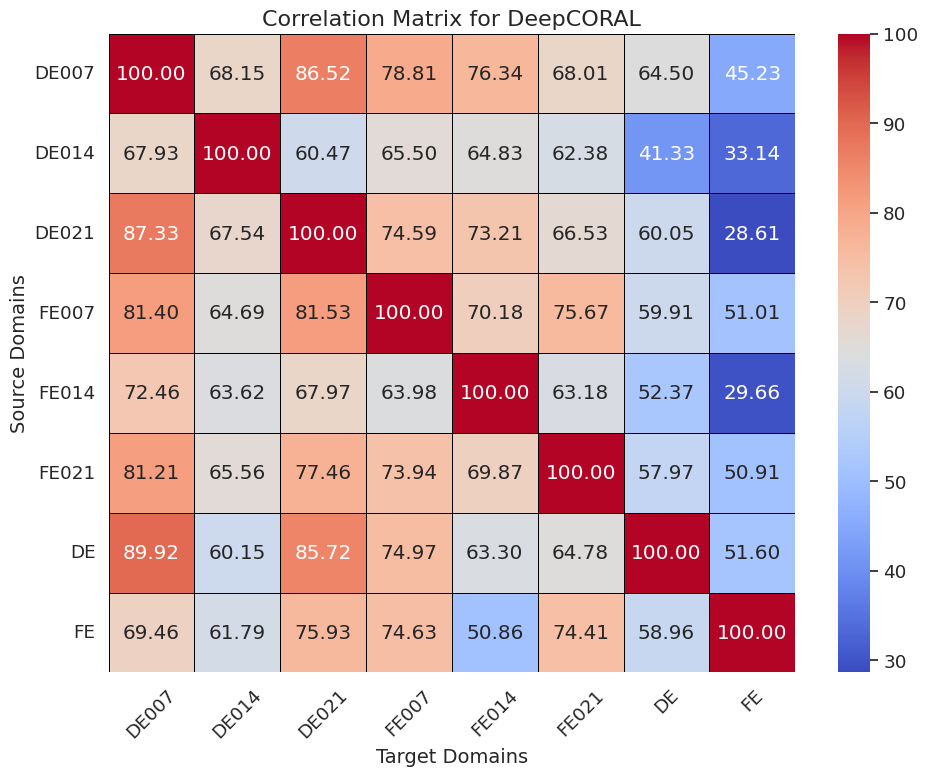

In [ ]:
if __name__ == "__main__":
    algo = 'DeepCORAL'

    for algo in ['DeepCORAL']:
        # Load source and target data
        datasets = ['DE007', 'DE014', 'DE021', 'FE007','FE014', 'FE021', 'DE', 'FE']
        for source in datasets:
            for target in datasets:
                # Load source and target data
                source_data, source_label = load_data(source)
                target_data, target_label = load_data(target)
                # Print names and shapes of source and target data
                print("Source domain:", source)
                print("Source data shape:", source_data.shape)
                print("Source label shape:", source_label.shape)
                print("Target domain:", target)
                print("Target data shape:", target_data.shape)
                print("Target label shape:", target_label.shape)

                # Convert NumPy arrays to TensorFlow tensors
                source_data = tf.convert_to_tensor(source_data, dtype=tf.float32)
                source_label = tf.convert_to_tensor(source_label, dtype=tf.int64)
                target_data = tf.convert_to_tensor(target_data, dtype=tf.float32)
                target_label = tf.convert_to_tensor(target_label, dtype=tf.int64)

                source_label = tf.one_hot(source_label, 4).numpy()
                target_label = tf.one_hot(target_label, 4).numpy()

                # Initialize the DEEPCORAL model with the defined networks
                encoder = get_encoder()
                task = get_task(activation="softmax", units=4)

                model = DeepCORAL(encoder=encoder, task=task, lambda_=0.1,
                            loss="categorical_crossentropy", optimizer=legacy.Adam(learning_rate=0.0001, beta_1=0.5),
                            copy=True, metrics=["acc"], random_state=0)

                # Define early stopping callback
                early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
                reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)

                # Train the model with early stopping
                model.fit(source_data, source_label, target_data, epochs=epochs,
                          validation_data=(target_data, target_label), callbacks=[early_stopping, reduce_lr])

                acc = model.evaluate(target_data, target_label, verbose=1)

                # Output loss value
                print("Loss value: {:.4f}".format(acc[0]))

                # Adjusted accuracy output to cap at 100%
                adjusted_accuracy = min(acc[1] * 100, 100)
                print("Accuracy value: {:.2f}%".format(adjusted_accuracy))

                # Save the accuracy to a file
                save_accuracy(algo, source, target, acc[1])

df = get_df(algo)
plot_corMatrix(df, algo)
